In [1]:
# import packages
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import json

# Variables
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/custom_mlp_model.pth'

/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
def extract_last_token_hidden_states(texts, model, tokenizer, batch_size=4):
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        # print("Size of last layer hidden states:", last_layer_hidden_states.size())
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        # print("last token hidden states:", last_token_hidden_states)
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

In [4]:
# lode data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement

In [5]:
# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=500, lr=0.001, checkpoint_path="/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/best_model.pth"):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')  # Initialize the best accuracy to negative infinity
    best_model_state = None  # Store the state of the best model
    best_epoch = 0  # Track the epoch with the best accuracy
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with accuracy {best_accuracy * 100:.2f}% at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Best Model was saved at epoch {best_epoch} with accuracy {best_accuracy * 100:.2f}%")
    return custom_mlp, losses, best_accuracy

In [6]:

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, y_non_infringement, infringement_outputs, y_infringement = load_data(non_infringement_file, infringement_file)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/anaconda3/envs/sit/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_last_token_hidden_states(non_infringement_outputs, model, tokenizer)

print("Extracting hidden states for infringement texts...")
X_infringement = extract_last_token_hidden_states(infringement_outputs, model, tokenizer)


Extracting hidden states for non_infringement texts...


Processing data batches:  12%|█▏        | 45/373 [11:52<3:04:57, 33.84s/it]

In [12]:
split_index_non_infringement = int(0.8 * len(X_non_infringement))
X_non_infringement_train = X_non_infringement[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement))
X_infringement_train = X_infringement[:split_index_infringement]
X_infringement_test = X_infringement[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")


Data successfully split into training and test sets.


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training Epochs:   3%|▎         | 16/500 [00:00<00:10, 47.34it/s]

Epoch 10/500, Loss: 0.5328
Test Accuracy at Epoch 10: 67.32%
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.94      0.31      0.47       211
non_infringement       0.62      0.98      0.76       245

        accuracy                           0.67       456
       macro avg       0.78      0.65      0.62       456
    weighted avg       0.77      0.67      0.63       456

New best model saved with accuracy 67.32% at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.94      0.31      0.47       211
non_infringement       0.62      0.98      0.76       245

        accuracy                           0.67       456
       macro avg       0.78      0.65      0.62       456
    weighted avg       0.77      0.67      0.63       456



Training Epochs:   5%|▌         | 27/500 [00:00<00:10, 46.92it/s]

Epoch 20/500, Loss: 0.3919
Test Accuracy at Epoch 20: 67.54%
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.73      0.47      0.57       211
non_infringement       0.65      0.85      0.74       245

        accuracy                           0.68       456
       macro avg       0.69      0.66      0.66       456
    weighted avg       0.69      0.68      0.66       456

New best model saved with accuracy 67.54% at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.73      0.47      0.57       211
non_infringement       0.65      0.85      0.74       245

        accuracy                           0.68       456
       macro avg       0.69      0.66      0.66       456
    weighted avg       0.69      0.68      0.66       456



Training Epochs:   8%|▊         | 38/500 [00:00<00:10, 45.97it/s]

Epoch 30/500, Loss: 0.3469
Test Accuracy at Epoch 30: 69.52%
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.79      0.47      0.59       211
non_infringement       0.66      0.89      0.76       245

        accuracy                           0.70       456
       macro avg       0.72      0.68      0.67       456
    weighted avg       0.72      0.70      0.68       456

New best model saved with accuracy 69.52% at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.79      0.47      0.59       211
non_infringement       0.66      0.89      0.76       245

        accuracy                           0.70       456
       macro avg       0.72      0.68      0.67       456
    weighted avg       0.72      0.70      0.68       456



Training Epochs:   9%|▊         | 43/500 [00:00<00:10, 42.47it/s]

Epoch 40/500, Loss: 0.3241
Test Accuracy at Epoch 40: 70.61%
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.83      0.46      0.59       211
non_infringement       0.66      0.92      0.77       245

        accuracy                           0.71       456
       macro avg       0.75      0.69      0.68       456
    weighted avg       0.74      0.71      0.69       456

New best model saved with accuracy 70.61% at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.83      0.46      0.59       211
non_infringement       0.66      0.92      0.77       245

        accuracy                           0.71       456
       macro avg       0.75      0.69      0.68       456
    weighted avg       0.74      0.71      0.69       456



Training Epochs:  11%|█         | 54/500 [00:01<00:09, 44.86it/s]

Epoch 50/500, Loss: 0.3078
Test Accuracy at Epoch 50: 69.52%
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.82      0.44      0.57       211
non_infringement       0.65      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.67       456



Training Epochs:  13%|█▎        | 66/500 [00:01<00:09, 47.25it/s]

Epoch 60/500, Loss: 0.3060
Test Accuracy at Epoch 60: 69.74%
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.82      0.44      0.57       211
non_infringement       0.66      0.92      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  15%|█▌        | 77/500 [00:01<00:08, 48.56it/s]

Epoch 70/500, Loss: 0.2947
Test Accuracy at Epoch 70: 69.96%
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.92      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.74      0.70      0.68       456



Training Epochs:  18%|█▊        | 88/500 [00:01<00:08, 49.23it/s]

Epoch 80/500, Loss: 0.2871
Test Accuracy at Epoch 80: 69.74%
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  20%|█▉        | 99/500 [00:02<00:08, 49.37it/s]

Epoch 90/500, Loss: 0.2812
Test Accuracy at Epoch 90: 69.74%
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  21%|██        | 104/500 [00:02<00:08, 48.29it/s]

Epoch 100/500, Loss: 0.3000
Test Accuracy at Epoch 100: 69.96%
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  23%|██▎       | 116/500 [00:02<00:07, 49.39it/s]

Epoch 110/500, Loss: 0.2793
Test Accuracy at Epoch 110: 69.74%
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.73      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  25%|██▌       | 127/500 [00:02<00:07, 49.59it/s]

Epoch 120/500, Loss: 0.2720
Test Accuracy at Epoch 120: 69.96%
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.92      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.74      0.70      0.68       456



Training Epochs:  28%|██▊       | 138/500 [00:02<00:07, 49.06it/s]

Epoch 130/500, Loss: 0.2680
Test Accuracy at Epoch 130: 69.30%
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.81      0.44      0.57       211
non_infringement       0.65      0.91      0.76       245

        accuracy                           0.69       456
       macro avg       0.73      0.68      0.67       456
    weighted avg       0.73      0.69      0.67       456



Training Epochs:  30%|██▉       | 149/500 [00:03<00:07, 49.57it/s]

Epoch 140/500, Loss: 0.2666
Test Accuracy at Epoch 140: 69.52%
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.83      0.43      0.57       211
non_infringement       0.65      0.92      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.67       456



Training Epochs:  31%|███       | 154/500 [00:03<00:07, 48.46it/s]

Epoch 150/500, Loss: 0.2631
Test Accuracy at Epoch 150: 69.74%
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 160/500, Loss: 0.2608


Training Epochs:  33%|███▎      | 165/500 [00:03<00:06, 48.34it/s]

Test Accuracy at Epoch 160: 69.30%
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.81      0.44      0.57       211
non_infringement       0.65      0.91      0.76       245

        accuracy                           0.69       456
       macro avg       0.73      0.68      0.67       456
    weighted avg       0.73      0.69      0.67       456



Training Epochs:  35%|███▌      | 176/500 [00:03<00:06, 48.69it/s]

Epoch 170/500, Loss: 0.2575
Test Accuracy at Epoch 170: 69.74%
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  37%|███▋      | 187/500 [00:03<00:06, 48.86it/s]

Epoch 180/500, Loss: 0.2586
Test Accuracy at Epoch 180: 69.52%
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.57       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.73      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  40%|███▉      | 198/500 [00:04<00:06, 49.28it/s]

Epoch 190/500, Loss: 0.2581
Test Accuracy at Epoch 190: 70.18%
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.78      0.49      0.60       211
non_infringement       0.67      0.88      0.76       245

        accuracy                           0.70       456
       macro avg       0.73      0.69      0.68       456
    weighted avg       0.72      0.70      0.69       456



Training Epochs:  42%|████▏     | 209/500 [00:04<00:05, 49.47it/s]

Epoch 200/500, Loss: 0.2554
Test Accuracy at Epoch 200: 69.96%
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 210/500, Loss: 0.2588
Test Accuracy at Epoch 210: 69.74%
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.82      0.44      0.57       211
non_infringement       0.66      0.92      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  45%|████▌     | 226/500 [00:04<00:07, 37.66it/s]

Epoch 220/500, Loss: 0.2644
Test Accuracy at Epoch 220: 71.27%
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.78      0.53      0.63       211
non_infringement       0.68      0.87      0.77       245

        accuracy                           0.71       456
       macro avg       0.73      0.70      0.70       456
    weighted avg       0.73      0.71      0.70       456

New best model saved with accuracy 71.27% at epoch 220
Best Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.78      0.53      0.63       211
non_infringement       0.68      0.87      0.77       245

        accuracy                           0.71       456
       macro avg       0.73      0.70      0.70       456
    weighted avg       0.73      0.71      0.70       456



Training Epochs:  47%|████▋     | 237/500 [00:05<00:06, 42.65it/s]

Epoch 230/500, Loss: 0.2595
Test Accuracy at Epoch 230: 70.18%
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.59       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.68       456
    weighted avg       0.73      0.70      0.68       456

Epoch 240/500, Loss: 0.2489


Training Epochs:  50%|████▉     | 248/500 [00:05<00:05, 46.59it/s]

Test Accuracy at Epoch 240: 69.96%
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 250/500, Loss: 0.2482
Test Accuracy at Epoch 250: 69.96%


Training Epochs:  52%|█████▏    | 259/500 [00:05<00:05, 48.18it/s]

Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 260/500, Loss: 0.2658
Test Accuracy at Epoch 260: 69.52%


Training Epochs:  54%|█████▍    | 270/500 [00:05<00:04, 48.02it/s]

Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.87      0.40      0.55       211
non_infringement       0.65      0.95      0.77       245

        accuracy                           0.70       456
       macro avg       0.76      0.67      0.66       456
    weighted avg       0.75      0.70      0.67       456

Epoch 270/500, Loss: 0.2681
Test Accuracy at Epoch 270: 69.96%
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  58%|█████▊    | 288/500 [00:06<00:04, 51.02it/s]

Epoch 280/500, Loss: 0.2511
Test Accuracy at Epoch 280: 69.96%
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 290/500, Loss: 0.2463


Training Epochs:  59%|█████▉    | 294/500 [00:06<00:04, 48.65it/s]

Test Accuracy at Epoch 290: 69.96%
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.81      0.46      0.59       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.73      0.68      0.68       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  61%|██████    | 306/500 [00:06<00:03, 50.22it/s]

Epoch 300/500, Loss: 0.2457
Test Accuracy at Epoch 300: 70.39%
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.81      0.47      0.60       211
non_infringement       0.67      0.90      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.69      0.68       456
    weighted avg       0.73      0.70      0.69       456

Epoch 310/500, Loss: 0.2438


Training Epochs:  64%|██████▎   | 318/500 [00:06<00:03, 50.69it/s]

Test Accuracy at Epoch 310: 69.74%
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.73      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 320/500, Loss: 0.2441


Training Epochs:  65%|██████▍   | 324/500 [00:06<00:03, 49.79it/s]

Test Accuracy at Epoch 320: 69.74%
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 330/500, Loss: 0.2482
Test Accuracy at Epoch 330: 69.74%


Training Epochs:  67%|██████▋   | 336/500 [00:07<00:03, 51.12it/s]

Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 340/500, Loss: 0.2472
Test Accuracy at Epoch 340: 70.39%
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.82      0.46      0.59       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.69      0.68       456
    weighted avg       0.74      0.70      0.69       456



Training Epochs:  71%|███████   | 354/500 [00:07<00:02, 50.50it/s]

Epoch 350/500, Loss: 0.2433
Test Accuracy at Epoch 350: 69.96%
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 360/500, Loss: 0.2421
Test Accuracy at Epoch 360: 70.18%


Training Epochs:  73%|███████▎  | 366/500 [00:07<00:02, 51.24it/s]

Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.59       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.68       456
    weighted avg       0.73      0.70      0.68       456

Epoch 370/500, Loss: 0.2408
Test Accuracy at Epoch 370: 69.74%
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.73      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  77%|███████▋  | 384/500 [00:08<00:02, 47.98it/s]

Epoch 380/500, Loss: 0.2400
Test Accuracy at Epoch 380: 69.96%
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  79%|███████▉  | 396/500 [00:08<00:02, 49.22it/s]

Epoch 390/500, Loss: 0.2764
Test Accuracy at Epoch 390: 69.74%
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.77      0.49      0.60       211
non_infringement       0.67      0.87      0.76       245

        accuracy                           0.70       456
       macro avg       0.72      0.68      0.68       456
    weighted avg       0.71      0.70      0.68       456



Training Epochs:  81%|████████▏ | 407/500 [00:08<00:01, 50.80it/s]

Epoch 400/500, Loss: 0.2762
Test Accuracy at Epoch 400: 70.83%
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.79      0.51      0.62       211
non_infringement       0.68      0.88      0.76       245

        accuracy                           0.71       456
       macro avg       0.73      0.69      0.69       456
    weighted avg       0.73      0.71      0.70       456

Epoch 410/500, Loss: 0.2624
Test Accuracy at Epoch 410: 69.74%


Training Epochs:  84%|████████▍ | 419/500 [00:08<00:01, 50.71it/s]

Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.58       211
non_infringement       0.66      0.91      0.76       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456

Epoch 420/500, Loss: 0.2542
Test Accuracy at Epoch 420: 70.18%


Training Epochs:  85%|████████▌ | 425/500 [00:08<00:01, 50.01it/s]

Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.85      0.43      0.57       211
non_infringement       0.66      0.93      0.77       245

        accuracy                           0.70       456
       macro avg       0.75      0.68      0.67       456
    weighted avg       0.75      0.70      0.68       456

Epoch 430/500, Loss: 0.2462
Test Accuracy at Epoch 430: 69.96%
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.81      0.45      0.58       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.67       456
    weighted avg       0.73      0.70      0.68       456



Training Epochs:  90%|████████▉ | 449/500 [00:09<00:00, 52.04it/s]

Epoch 440/500, Loss: 0.2419
Test Accuracy at Epoch 440: 71.05%
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.82      0.48      0.60       211
non_infringement       0.67      0.91      0.77       245

        accuracy                           0.71       456
       macro avg       0.75      0.69      0.69       456
    weighted avg       0.74      0.71      0.69       456

Epoch 450/500, Loss: 0.2405
Test Accuracy at Epoch 450: 70.83%


Training Epochs:  91%|█████████ | 455/500 [00:09<00:00, 50.90it/s]

Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.81      0.48      0.60       211
non_infringement       0.67      0.91      0.77       245

        accuracy                           0.71       456
       macro avg       0.74      0.69      0.69       456
    weighted avg       0.74      0.71      0.69       456

Epoch 460/500, Loss: 0.2395
Test Accuracy at Epoch 460: 71.05%
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.83      0.47      0.60       211
non_infringement       0.67      0.91      0.77       245

        accuracy                           0.71       456
       macro avg       0.75      0.69      0.69       456
    weighted avg       0.74      0.71      0.69       456



Training Epochs:  96%|█████████▌| 479/500 [00:10<00:00, 51.13it/s]

Epoch 470/500, Loss: 0.2387
Test Accuracy at Epoch 470: 70.83%
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.82      0.47      0.60       211
non_infringement       0.67      0.91      0.77       245

        accuracy                           0.71       456
       macro avg       0.74      0.69      0.69       456
    weighted avg       0.74      0.71      0.69       456



Training Epochs:  97%|█████████▋| 485/500 [00:10<00:00, 48.52it/s]

Epoch 480/500, Loss: 0.2384
Test Accuracy at Epoch 480: 71.27%
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.83      0.48      0.61       211
non_infringement       0.67      0.91      0.77       245

        accuracy                           0.71       456
       macro avg       0.75      0.70      0.69       456
    weighted avg       0.74      0.71      0.70       456



Training Epochs:  99%|█████████▉| 496/500 [00:10<00:00, 49.76it/s]

Epoch 490/500, Loss: 0.2641
Test Accuracy at Epoch 490: 70.18%
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.82      0.45      0.59       211
non_infringement       0.66      0.91      0.77       245

        accuracy                           0.70       456
       macro avg       0.74      0.68      0.68       456
    weighted avg       0.73      0.70      0.68       456

Epoch 500/500, Loss: 0.2420
Test Accuracy at Epoch 500: 70.61%


Training Epochs: 100%|██████████| 500/500 [00:10<00:00, 47.70it/s]
/tmp/ipykernel_3567658/3419765604.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_sta

Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.83      0.46      0.59       211
non_infringement       0.66      0.92      0.77       245

        accuracy                           0.71       456
       macro avg       0.75      0.69      0.68       456
    weighted avg       0.74      0.71      0.69       456



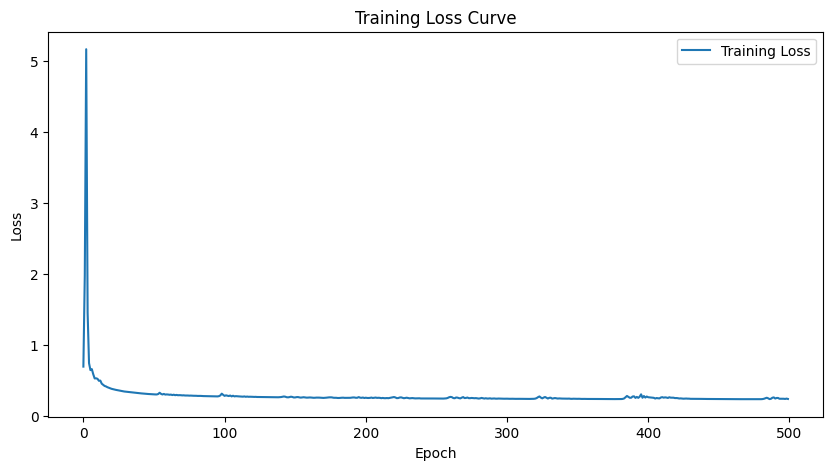

Best Model was saved at epoch 220 with accuracy 71.27%


In [13]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [14]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/custom_mlp_model.pth'.


In [15]:
print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

Final Model Accuracy: 71.27%
                  precision    recall  f1-score   support

    infringement       0.78      0.53      0.63       211
non_infringement       0.68      0.87      0.77       245

        accuracy                           0.71       456
       macro avg       0.73      0.70      0.70       456
    weighted avg       0.73      0.71      0.70       456



/tmp/ipykernel_3567658/3740627605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
